# <center> Controls on diabatic Eddies </center> #

Having established a significant response in the diabatic eddy heat flux divergence it is now important to understand what controls this response. Here we look at the effects of diabatic layer depth, eddy kinetic energy (EKE) and isopycnal slope in the diabatic layer.

* Increase in velocity from EKE 
* Increase in diabatic layer depth
* Increase in APE / residual  *first lets see how the match*


In [284]:
# Load in Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy.ma as ma
import sys
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from HB_Plot import nf, fmt
import SG
import useful as hb
import layers_calc_numba
import APE_Calc as AC
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

tau = ['3', '300', '3000', 'Closed']

Figletter = ['a) ','b) ','c) ','d)' ]

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/VSQ.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

In [747]:
Dsum = []
Vsum = []
Darea = []
APEt = []
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)

    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
 
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.sum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2)/5000)
    
    # Diabatic eddis from new def
    dx = 5000
    nx = 200
    Dz = dx*((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).mean(axis=2)/nx - dPz
    Dy = dx*((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).mean(axis=2)/nx - dPy
    D = np.cumsum(abs(Dy),axis=1)
   
      
    # Diabatic layer area
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
        if i ==2:
     
            a = a+17
        if a<41 and depths[a-1,jj] - depths[a,jj] > 80:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            
            DDL[jj] = depths[a,jj]

    # Diabatic area mask
    Zmatrix = np.tile(c.zc,(c.Ny,1)).T
    for jj in range(c.Ny):
        Zval = -Zmatrix[:,jj]
        Zmatrix[Zval>DDL[jj],jj] = 0
        #Zmatrix[Zval<=DDL[jj],jj] = 1
    V = c.calc_EKE()
    g = AC.APEcomputer(c)
    APE = g.calc_APE()
    if i == 0:
        D0 = np.sum(D)
        V0 = np.sum(V*CellVol.mean(axis=2))
        DDL0 = np.sum(DDL)
        APE0 = np.sum(APE.mean(axis=1))
    #DDL[DDL==0]=np.nan
    

    
    incD = (np.sum(D)-D0)/D0
    incV = (np.sum(abs(V)*CellVol.mean(axis=2))-V0)/V0
    incDdl = (np.sum(DDL)-DDL0)/DDL0
    incAPE = (np.sum(APE.mean(axis=1))-APE0)/APE0
    
    Dsum.append(incD)
    Vsum.append(incV)
    Darea.append(incDdl)
    APEt.append(incAPE)
Dsum = np.array(Dsum)
Vsum = np.array(Vsum)
Darea = np.array(Darea)
APEt = np.array(APEt)

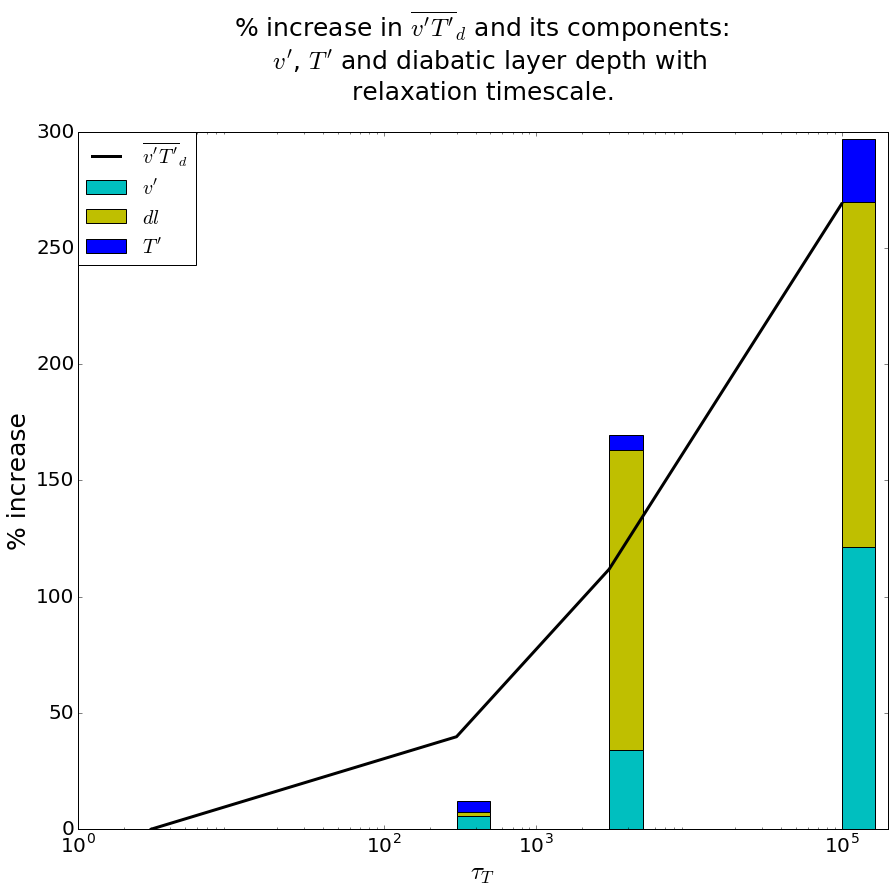

In [769]:
fig = plt.figure(figsize=(14.5, 12.5))
Tau = [3,300,3000,10**5]
p = plot(Tau,Dsum*100,'k',linewidth=3)
p1 = plt.bar(Tau,Vsum*100,width=np.array(Tau)/1.5, color='c')
p2 = plt.bar(Tau,Darea*100 , width=np.array(Tau)/1.5, color='y',bottom=Vsum*100)
p3 = plt.bar(Tau,APEt*100, width=np.array(Tau)/1.5, color='b',bottom=(Vsum+Darea)*100)
#ylim(0,1.2)
plt.xscale("log")
plt.xlim(0,2*10**5)
xticks([10**0,10**2,10**3,10**5], fontsize=20)
yticks(fontsize=20)
xlabel(r'$\tau _{T}$', fontsize=25)
ylabel(r'% increase', fontsize=25)
title("% increase in $\overline{v^\prime T ^\prime}_{d}$ and its components: \n  $v ^\prime$, $T ^\prime$ and diabatic layer depth with \n relaxation timescale. \n",fontsize=25)
lgd = plt.legend([r'$\overline{v^\prime T ^\prime}_{d}$',r'$v ^\prime$',r'$dl$',r'$T ^\prime$',
                  'Q'], loc=2, borderaxespad=0.,fontsize=20)

In [754]:
Darea

array([ 0.        ,  0.01660281,  1.2903801 ,  1.48243987])

In [752]:
(Darea/Dsum)[1::].mean()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


0.58236389558831159

In [753]:
(Vsum/Dsum)[1::].mean()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


0.30018738267686201

In [666]:
APEt/Dsum

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


array([        nan,  0.12052425,  0.05761225,  0.10000458])

In [712]:
Vsum = []
VTsum = []
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)

    VTe = c.vgrid_to_cgrid( VT - V*Tv )

 
    V = np.sqrt(c.calc_EKE())
  
    if i == 0:
        VT0 = np.sum(VTe.mean(axis=2)*CellVol.mean(axis=2))
        V0 = np.sum(V*CellVol.mean(axis=2))


    Vsum.append((np.sum(V*CellVol.mean(axis=2))-V0)/V0)
    VTsum.append((np.sum(VTe.mean(axis=2)*CellVol.mean(axis=2))-VT0)/VT0)
VTsum = np.array(VTsum)
Vsum = np.array(Vsum)


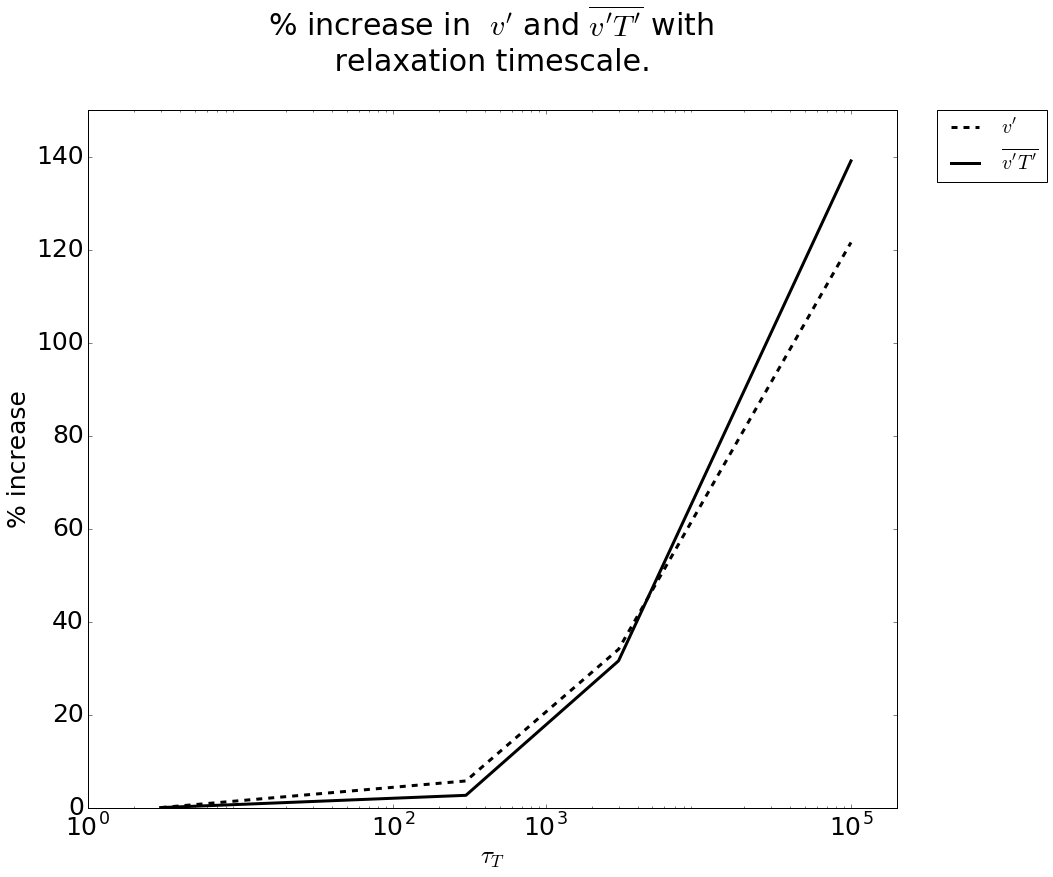

In [774]:
fig = plt.figure(figsize=(14.5, 12.5))
Tau = [3,300,3000,10**5]
p = plot(Tau,Vsum*100,'--k',linewidth=3)
p1 = plot(Tau,VTsum*100,'k',linewidth=3)
ylim(0,150)
plt.xscale("log")
plt.xlim(0,2*10**5)
xticks([10**0,10**2,10**3,10**5], fontsize=25)
yticks(fontsize=25)
xlabel(r'$\tau _{T}$', fontsize=25)
ylabel(r'% increase', fontsize=25)
title("% increase in  $v ^\prime$ and $\overline{v^\prime T ^\prime}$ with \n relaxation timescale. \n",fontsize=30)
lgd = plt.legend([r'$v ^\prime$',r'$\overline{v^\prime T ^\prime}$'
                 ],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

In [714]:
Vsum/VTsum

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


array([        nan,  0.9431607 ,  0.36028877,  0.29996657])

In [719]:
Vsum*100

array([  0.        ,   2.48812195,  11.36897332,  41.71767156])